# Sea surface currents (SSC) prediction from Himawari-8/9 SST 

Using the Gaussian Process method of de Kreij et al., 2025.

### In this tutorial:
1. Download and preprocess Himawari-8/9 SST data
2. View the SST data and spatial and temporal gradients
3. Perform Gaussian Process regression and inspect the hyper-parameter results
4. View the surface current predictions and uncertainties

Only a single prediction time step is shwon in this tutorial. To process many time steps see tutorial 3. 

In [1]:
import os
import glob
import shutil
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from inversion_sst_gp import plots
from inversion_sst_gp import gp_regression as gpr
from inversion_sst_gp.download import himawari
from inversion_sst_gp import utils

%matplotlib inline

# sudo mount -t drvfs '\\drive.irds.uwa.edu.au\OGS-ODFDA-001' /mnt/share

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:258: SyntaxWarning: invalid escape sequence '\c'
  cbar_kwargs={'pad':0.03, 'shrink':0.5, 'label':'T [$^{\circ}$C]'})
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:338: SyntaxWarning: invalid escape sequence '\c'
  cbar_kwargs = {'pad':0.03, 'shrink':0.5, 'label':'T [$^{\circ}$C]'}
/home/wedge/anaconda3/envs/sstinv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Download himawari data

##### Set geographical limits and chose a time step

*Note that ~3 x 3 degree boxes are a recommended maximum area for reasonable processing on personal computers.*

In [2]:
# Define geographical and temporal boundaries for data processing
LON_LIMITS = (112.35, 113.85)
LAT_LIMITS = (-20.75, -19.45)  
ll_box = (LON_LIMITS, LAT_LIMITS)

# Set the time bounds - predictions will be done hourly within these limits
time_lims = ["2024-05-01T00:00:00", "2024-10-01T00:00:00"]

crop_app = 'scarborough_winter24'

# Set the save directory for the data (recommend this directory is ignored by git if inside the repo)
base_dir = os.path.join('/mnt', 'd', 'Work_backup', 'C_drive', 'Large_Data')
alldata_dir = os.path.join(base_dir, 'Other', 'Himawari', 'all')
cropped_dir = os.path.join(base_dir, 'Other', 'Himawari', crop_app)

##### Retrieve the required complete Himawari data files

Some files don't exist on the server. These timesteps will not get a velocity prediction.

In [3]:
# # Download the data
# himawari.get_sst_series_nasa(time_lims, alldata_dir)

In [4]:
# # Crop himawari files (optional)

# # Setting ow=True will delete the original files after cropping (can also just set file_app='')
# himawari.crop_sst_series_nasa(alldata_dir, time_lims, ll_box, file_app=crop_app, overwrite=False)

In [5]:
# Move the new files to another folder
move_files = glob.glob(os.path.join(alldata_dir, f'*{crop_app}.nc'))
for mf in move_files:
    f_name = os.path.split(mf)[1]
    shutil.move(mf, os.path.join(cropped_dir, f_name))

In [6]:
# # Load the data
# ds = himawari.process_sst_series(cropped_dir, time_lims, ll_box, file_app=crop_app, sst_reduce=2)
# ds

In [7]:
# Optional: save joined DS and delete individual cropped files
# ds.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_compiled.nc'))
ds

<xarray.Dataset> Size: 147MB
Dimensions:    (time: 3655, lat: 33, lon: 38)
Coordinates:
  * time       (time) datetime64[ns] 29kB 2024-05-01 ... 2024-09-30T23:00:00
  * lat        (lat) float64 264B -20.74 -20.7 -20.66 ... -19.54 -19.5 -19.46
  * lon        (lon) float64 304B 112.4 112.4 112.4 112.5 ... 113.8 113.8 113.8
    LON        (lat, lon) float64 10kB ...
    LAT        (lat, lon) float64 10kB ...
    X          (lat, lon) float64 10kB ...
    Y          (lat, lon) float64 10kB ...
    lonc       float64 8B ...
    latc       float64 8B ...
    time_step  int64 8B ...
Data variables:
    T          (time, lat, lon) float64 37MB ...
    dTdt       (time, lat, lon) float64 37MB ...
    dTdx       (time, lat, lon) float64 37MB ...
    dTdy       (time, lat, lon) float64 37MB ...

---
# Run the parameter optimization

##### Running on the first time step only

This is acceptable for short time series where it is expected that the hyper-parameters do not change significantly over time.

In [8]:
# Set model hyperparameters
prop_sat = gpr.get_default_params()

# Run model
print("Running GP optimization")

# Set the time interval for refitting hyperparameters - if this is less than 1 hr, refitting will occur at every time step
refit_time = np.timedelta64(3, 'D').astype('timedelta64[ns]')

# results_step = gpr.fit_series(ds, prop_sat, refit_time, save_steps=True, save_name=os.path.join(cropped_dir, f'{crop_app}_fits_3D.nc'), callback='off', coverage=0.8)

Running GP optimization


In [9]:
ds_results = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_fits_3D.nc'))
ds_results.close()

In [10]:
print("Calculating GP regression prediction")
# ds_full = gpr.predict_series(ds.sel(time=ds_results.time), ds_results)
# ds_full.to_netcdf(path=os.path.join(cropped_dir, f'{crop_app}_predictions_3D.nc'))
ds_full = xr.open_dataset(os.path.join(cropped_dir, f'{crop_app}_predictions_3D.nc'))

Calculating GP regression prediction


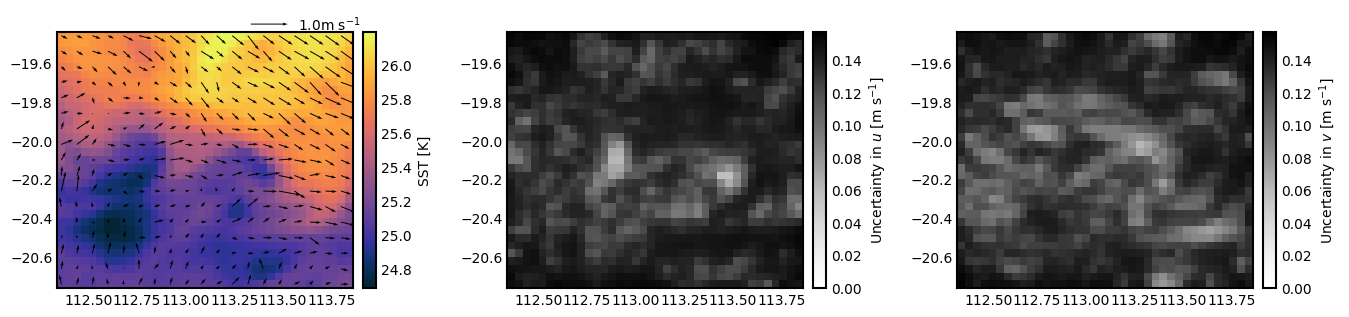

In [18]:
fig, ax = plots.plot_prediction(ds_full.sel(time=('2024-07-19T22')), qk_size=1., qv_scale=8, thin=2)

In [12]:
ds_restrim = ds_results.copy()
ds_restrim = ds_restrim.dropna(dim='time')

# This removes repeated parameters so we can just see where the fits were done
ds_restrim = utils.clean_dataset(ds_restrim)

# If you prefer to have nan instead of missing time steps
ds_full_hourly = utils.make_even_hourly(ds_full)
ds_restrim_hourly = utils.make_even_hourly(ds_restrim)

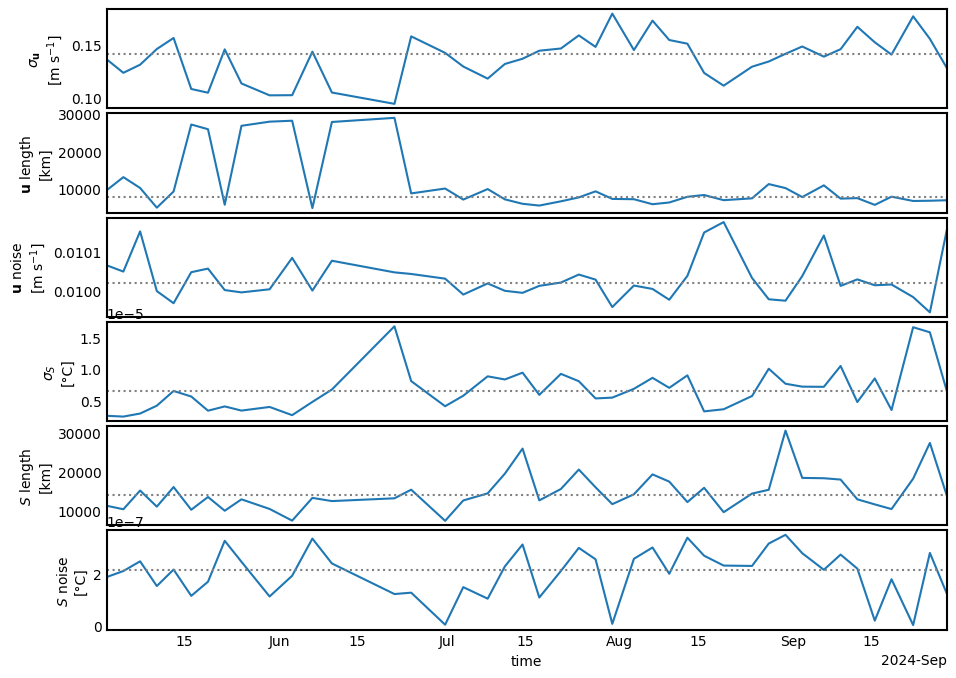

In [13]:
fig, ax = plots.plot_param_series(ds_restrim)

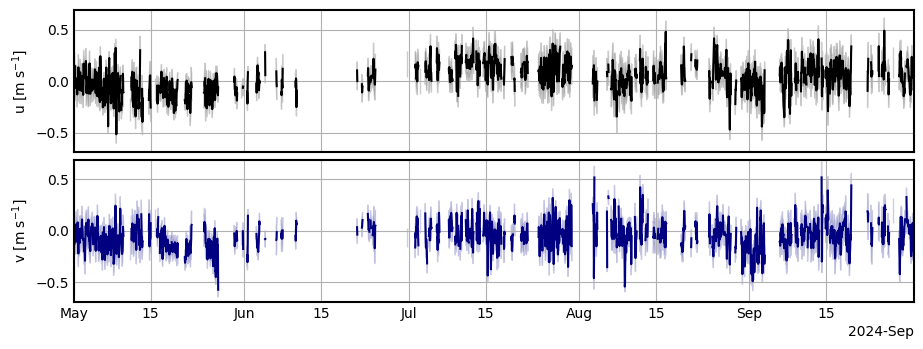

In [14]:
fig, ax = plots.plot_timeseries(ds_full_hourly, lon_pt=113.2416, lat_pt=-19.926)
for x in ax:
    x.set_ylim(-0.69,0.69)
    # x.set_xlim(np.datetime64(time_lims[0]) + np.timedelta64(0,'D'), np.datetime64(time_lims[0]) + np.timedelta64(28,'D'))

/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:363: RuntimeWarning: All-NaN axis encountered
  frame_vmin = np.nanmin(ds.isel(time=frame)[T_name])
/mnt/c/Users/00099894/OneDrive - The University of Western Australia/pl/uwadev/inversion-sst-gp/pkg/inversion_sst_gp/plots.py:364: RuntimeWarning: All-NaN axis encountered
  frame_vmax = np.nanmax(ds.isel(time=frame)[T_name])


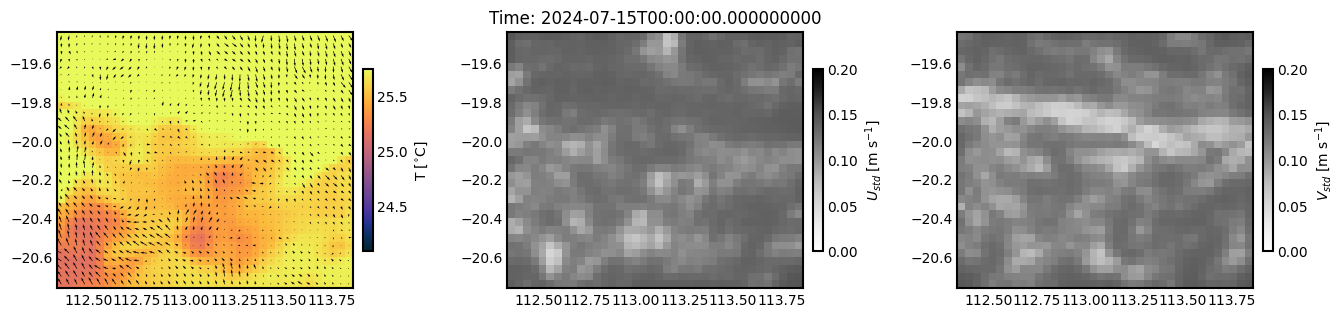

In [16]:
# from IPython.display import HTML
# %matplotlib notebook

ani = plots.plot_prediction_animation(ds_full_hourly.sel(time=slice('2024-07-15', '2024-08-30')), qv_scale=12, anim_interval=150, smoothing=0.08)
ani.save(f'{crop_app}_animation_August_front.mp4')
# HTML(ani.to_jshtml())